# Catégorisation des photos

In [1]:
import os
from os import listdir
import warnings
import time
import datetime

import pandas as pd
import numpy as np

import json
import ijson

import matplotlib.pyplot as plt
from matplotlib.image import imread
import seaborn as sns

from PIL import Image
from PIL import ImageOps, ImageFilter
import PIL.Image as Image

import cv2

import plotly.express as px

from tqdm.notebook import trange, tqdm

from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
from sklearn import preprocessing
from sklearn import cluster, metrics
from sklearn.metrics import silhouette_score
from sklearn import manifold, decomposition
from sklearn.manifold import TSNE

import tensorflow as tf
import tensorflow_hub as hub
%load_ext tensorboard

## Préparation des données

Nos données sont sous format **jpg** dans le dossier "data/yelp_photos/photos".

Nous allons maintenant créer une fonction de préprocess d'image, cette fonction effectuera les étapes suivantes :

- Conversion des images en gris
    - L'histogramme d'une image numérique est une courbe statistique représentant la répartition de ses pixels selon leur intensité. Pour une image en noir et blanc, il indique en **abscisse le niveau de gris (entier entre 0 et 255)** et en **ordonnée, le nombre de pixels ayant cette valeur**.

- Égalisation
    - Puis nous devons ensuite l'égaliser, l'égalisation est une technique simple permettant de réajuster le contraste d'une image.

- Et filtration
    - Le principe du filtrage est de nettoyer l'image en éliminant le plus de bruit possible.

**En mathématiques, une image est une fonction**. Cette fonction quantifie l'intensité lumineuse de n'importe quel point dans l'image. Dans une image en noir et blanc, l'intensité est **le niveau de gris** : plus un point est **sombre**, plus son niveau de gris est **faible**.

In [2]:
def img_preprocess(img, repertoire):
    print("Image brute")
    display(img)
    # Convertis l'image en gris
    img_grey = img.convert('L')
    # Charge l'image comme matrice de pixels
    img_grey_array = np.array(img_grey)
    # Génère et affiche l'histogramme
    plt.title('Répartition des pixels niveau de gris brute')
    n, bins, patches = plt.hist(img_grey_array.flatten(), bins=range(256))
    plt.show()
    # Égalisation
    img_egalise = ImageOps.equalize(img_grey)
    # Filtrage
    img_filtre = img_egalise.filter(ImageFilter.MedianFilter)
    # Charge l'image comme matrice de pixels
    img_filtre_array = np.array(img_filtre)
    plt.title('Répartition des pixels après préprocess')
    n, bins, patches = plt.hist(img_filtre_array.flatten(), bins=range(256))
    plt.show()
    print("Image après préprocess")
    display(img_filtre)
    # Sauvegarde l'image
    img_filtre.save(fp=repertoire)

Image brute


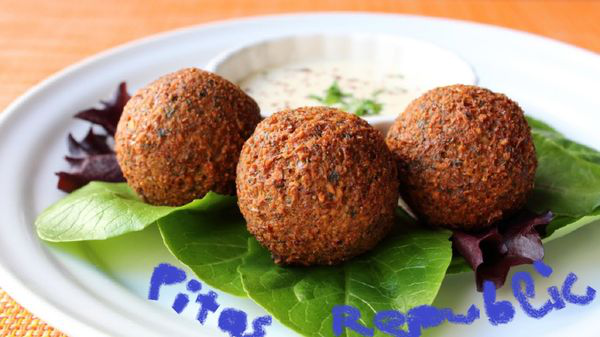

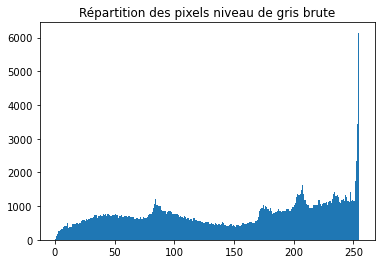

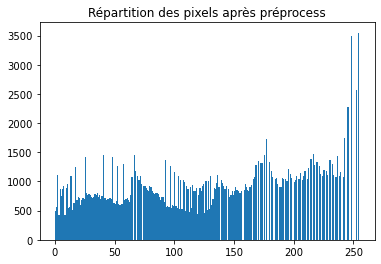

Image après préprocess


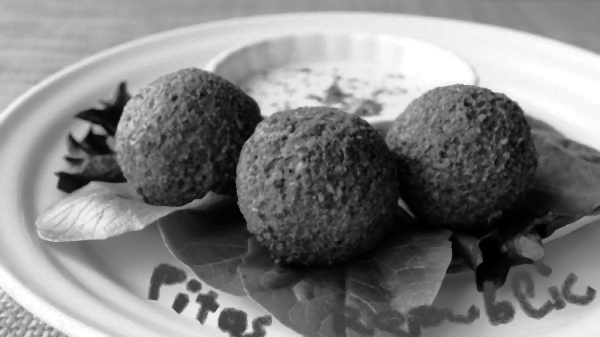

In [3]:
image = Image.open('data/yelp_photos/photos/_0ee3H6AP0W85VBOUiwWsQ.jpg')
img_preprocess(image, 'data/photo_preprocess/image1.jpg')
image_preprocess = Image.open('data/photo_preprocess/image1.jpg')

# SIFT test

SIFT, ou Scale Invariant Feature Transform est un algorithme de détection des caractéristiques d'image.

SIFT permet de **localiser les caractéristiques locales d'une image**, communément appelées "points clés" de l'image. Ces points clés sont **invariants en termes d'échelle et de rotation** et peuvent être utilisés pour diverses applications de vision par ordinateur, comme la comparaison d'images, la détection d'objets, la détection de scènes, etc.

Nous pouvons également utiliser les points clés générés à l'aide de SIFT comme caractéristiques de l'image pendant l'apprentissage du modèle. Le principal avantage des caractéristiques SIFT, est que **les images ne sont pas affectées par la taille ou l'orientation de l'image**.

Nous allons générer les caractéristiques SIFT. Tout d'abord, nous devons **construire un objet SIFT**, puis utiliser la fonction **detectAndCompute** pour obtenir les points clés. 

Déterminons les points clés et imprimons le nombre total de points clés trouvés dans notre image.

[ WARN:0] global /home/conda/feedstock_root/build_artifacts/libopencv_1619749214432/work/opencv_contrib/modules/xfeatures2d/misc/python/shadow_sift.hpp (13) SIFT_create DEPRECATED: cv.xfeatures2d.SIFT_create() is deprecated due SIFT tranfer to the main repository. https://github.com/opencv/opencv/issues/16736


1593

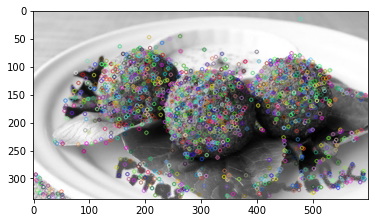

In [4]:
# Charge l'image en array
img1 = cv2.imread('data/yelp_photos/photos/_0ee3H6AP0W85VBOUiwWsQ.jpg')
# Prépocess l'array de l'image
gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)

# Points clefs
sift = cv2.xfeatures2d.SIFT_create()
keypoints_1, descriptors_1 = sift.detectAndCompute(img1, None)

img_1 = cv2.drawKeypoints(gray1, keypoints_1, img1)
plt.imshow(img_1)
len(keypoints_1)

# Features matching

Pour vérifier que SIFT fonctionne bien, nous allons utiliser deux images identiques, mais sous des angles différents pour voir si les points clés sont bien répartis de la même manière pour les deux images.

Étant donné que nous avons de grandes quantités de données, il serait très difficile de trouver de mêmes images sous des angles différents.
Nous allons donc pour ce test utiliser deux images qui ne sont pas présentes dans notre dataset.

C'est un exemple simple de voir la correspondance des caractéristiques entre deux images.

In [5]:
img_test1 = cv2.imread('data/photo_feature_matching/tour_de_pise_1.jpg')
img_test2 = cv2.imread('data/photo_feature_matching/tour_de_pise_2.jpg')

img_test1 = cv2.cvtColor(img_test1, cv2.COLOR_BGR2GRAY)
img_test2 = cv2.cvtColor(img_test2, cv2.COLOR_BGR2GRAY)

#sift
sift = cv2.xfeatures2d.SIFT_create()

keypoints_1, descriptors_1 = sift.detectAndCompute(img_test1, None)
keypoints_2, descriptors_2 = sift.detectAndCompute(img_test2, None)

len(keypoints_1), len(keypoints_2)

(755, 332)

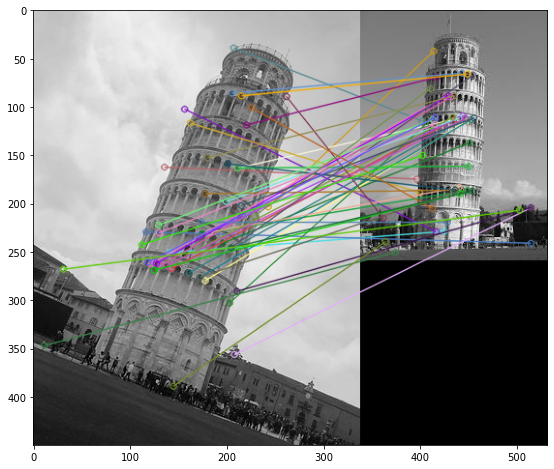

(<matplotlib.image.AxesImage at 0x7fc648534490>, None)

In [6]:
# feature matching
bf = cv2.BFMatcher(cv2.NORM_L1, crossCheck=True)

matches = bf.match(descriptors_1, descriptors_2)
matches = sorted(matches, key=lambda x: x.distance)

figure = plt.subplots(1, figsize=(16, 8))

img_test3 = cv2.drawMatches(img_test1,
                            keypoints_1,
                            img_test2,
                            keypoints_2,
                            matches[:50],
                            img_test2,
                            flags=2)
plt.imshow(img_test3), plt.show()

SIFT fonctionne bien et a reconnu par les principaux points clés.

Faisons maintenant la même chose avec nos données, ajoutons une image en plus qui sera comparée avec notre première image de boulettes.

In [7]:
img_1 = cv2.imread('data/yelp_photos/photos/_0ee3H6AP0W85VBOUiwWsQ.jpg')
img_2 = cv2.imread('data/yelp_photos/photos/_0khc7w9yn6ljYy8PCT3fQ.jpg')

img_1 = cv2.cvtColor(img_1, cv2.COLOR_BGR2GRAY)
img_2 = cv2.cvtColor(img_2, cv2.COLOR_BGR2GRAY)

#sift
sift = cv2.xfeatures2d.SIFT_create()

keypoints_1, descriptors_1 = sift.detectAndCompute(img_1, None)
keypoints_2, descriptors_2 = sift.detectAndCompute(img_2, None)

len(keypoints_1), len(keypoints_2)

(1593, 1277)

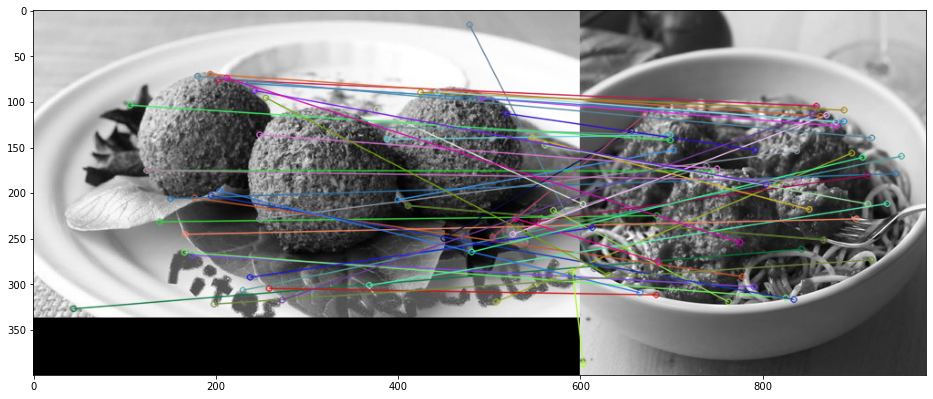

(<matplotlib.image.AxesImage at 0x7fc6495bb2e0>, None)

In [8]:
# feature matching
bf = cv2.BFMatcher(cv2.NORM_L1, crossCheck=True)

matches = bf.match(descriptors_1, descriptors_2)
matches = sorted(matches, key=lambda x: x.distance)

figure = plt.subplots(1, figsize=(16, 8))

img_3 = cv2.drawMatches(img_1,
                        keypoints_1,
                        img_2,
                        keypoints_2,
                        matches[:50],
                        img_2,
                        flags=2)
plt.imshow(img_3), plt.show()

# Dataset

Chargons maintenant notre jeu de données.

In [9]:
df_photo = pd.read_csv('data/yelp_dataset/csv/df_photo.csv',
                       lineterminator='\n')

Nous n'en utiliserons que 1600, en effet, nous voulons créer une dataframe regroupant les catégories, mais avec des quantités identiques, comme la quantité 'menu' n'a que 1678 lignes, alors nous ne prendrons que 1600 lignes.

In [10]:
n_sample = 1600

food_sample = df_photo[df_photo["label_name"].isin(["food"])].sample(n_sample)
inside_sample = df_photo[df_photo["label_name"].isin(["inside"
                                                      ])].sample(n_sample)
outside_sample = df_photo[df_photo["label_name"].isin(["outside"
                                                       ])].sample(n_sample)
drink_sample = df_photo[df_photo["label_name"].isin(["drink"
                                                     ])].sample(n_sample)
menu_sample = df_photo[df_photo["label_name"].isin(["menu"])].sample(n_sample)

sample_df_photo = pd.concat(
    [food_sample, inside_sample, outside_sample, drink_sample, menu_sample])
sample_df_photo["label_name"].value_counts()

food       1600
inside     1600
outside    1600
drink      1600
menu       1600
Name: label_name, dtype: int64

Voyons quelques images par label.

-----------------------------------
food


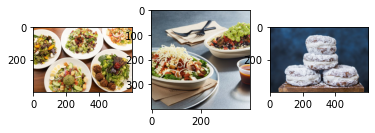

-----------------------------------
inside


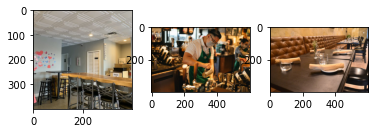

-----------------------------------
outside


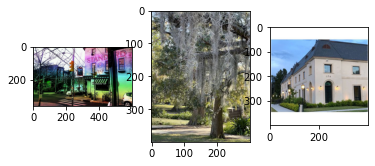

-----------------------------------
drink


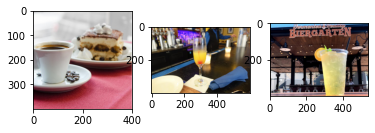

-----------------------------------
menu


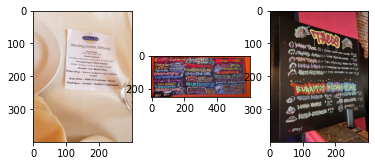

In [11]:
list_labels = ["food", "inside", "outside", "drink", "menu"]
path = "data/yelp_photos/photos/"
for name in list_labels:
    print("-------" * 5)
    print(name)
    sample_df_photo_label = df_photo[df_photo["label_name"].isin([name])]
    photo_list = sample_df_photo_label["photo_id"].to_list()
    for i in range(3):
        plt.subplot(130 + 1 + i)
        filename = path + photo_list[i + 5] + ".jpg"
        image = imread(filename)
        plt.imshow(image)
    plt.show()

# SIFT

Reprenons les codes de notre section "SIFT test".

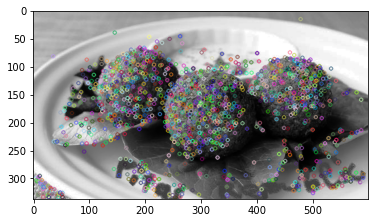

Descripteurs :  (1489, 128)
------------
[[ 40.  57.  17. ...  17. 112. 124.]
 [ 55.  31.   5. ...   4.  25. 111.]
 [ 14.  11.   7. ...   8.  31.  51.]
 ...
 [ 30.  12.   1. ...   0.   2.  73.]
 [  0.   0.   0. ...   5.   1.   0.]
 [  2.   8.  98. ...   0.   0.  32.]]


In [12]:
sift = cv2.SIFT_create()
image = cv2.imread(path + '_0ee3H6AP0W85VBOUiwWsQ.jpg', 0)
image = cv2.equalizeHist(image)

key_point, descriptors = sift.detectAndCompute(image, None)
img = cv2.drawKeypoints(image, key_point, image)
plt.imshow(img)
plt.show()

print("Descripteurs : ", descriptors.shape)
print("------------")
print(descriptors)

Ces zones peuvent correspondre à des contours, des points ou des régions d'intérêt. À chaque feature détectée **(point clé)** est associé un vecteur, appelé descripteur (feature descriptor ou feature vector), qui, comme son nom l'indique, décrit la zone concernée.

L'image en contient 2350, car l'image choisie est un menu, il y a beaucoup d'écritures.

Chaque descripteur est un vecteur de longueur 128.

-----------------------------------


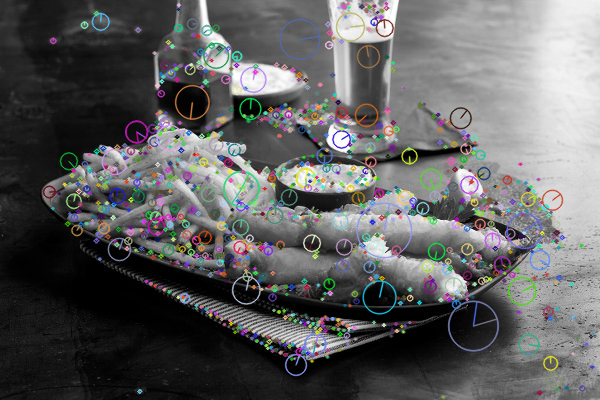

Descripteurs :  (1255, 128)

-----------------------------------


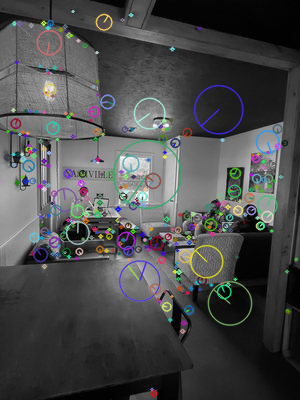

Descripteurs :  (425, 128)

-----------------------------------


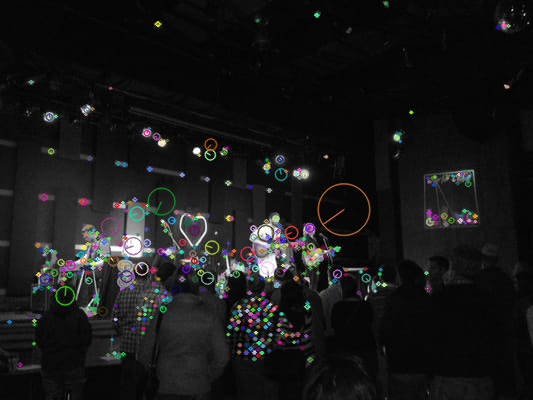

Descripteurs :  (724, 128)



In [13]:
# Nous allons appliquer notre traitement sur plusieurs images
for i in range(0, 3):
    print("-------" * 5)
    # Tous les n_sample (1600) la catégorie change.
    # C'est pour cela que l'on multiplie l'index par n_sample.
    img = cv2.imread(path + sample_df_photo.iloc[i * n_sample].photo_id +
                     ".jpg")
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    sift = cv2.SIFT_create()
    key_point, descriptors = sift.detectAndCompute(gray, None)

    img = cv2.drawKeypoints(gray, key_point, img)
    img = cv2.drawKeypoints(gray,
                            key_point,
                            img,
                            flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

    display(Image.fromarray(img, "RGB"))
    print("Descripteurs : ", descriptors.shape)
    print()

Nous avons beaucoup de descripteurs. L'intérêt est de ne pas en avoir trop de manière à avoir une feature bien définie.

Par exemple, si nous avons une image représentant un visage, et que nous obtenons 500 descripteurs, nous avons un problème.
En effet, le but est d'avoir un descripteur bien défini comme :
- Le nez
- La bouche
- Les deux yeux
- etc.

Nous pouvons ajouter un flou gaussien pour en réduire le nombre.

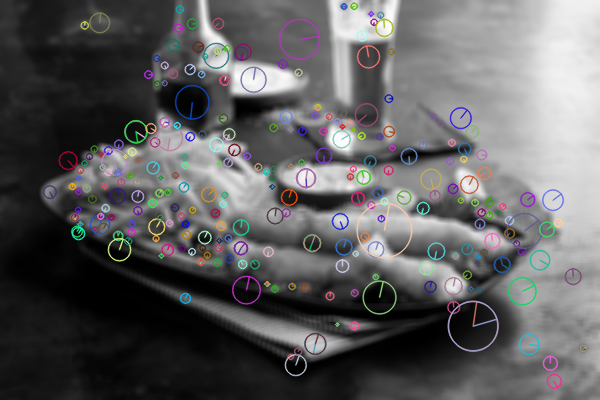

Descripteurs :  (304, 128)



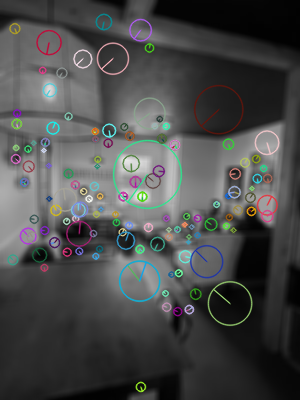

Descripteurs :  (158, 128)



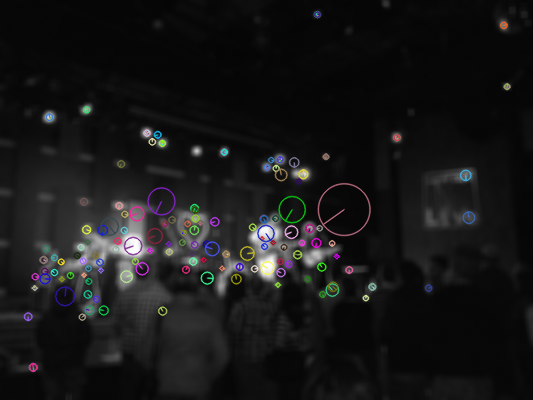

Descripteurs :  (183, 128)



In [14]:
for i in range(0, 3):

    img = cv2.imread(path + sample_df_photo.iloc[i * n_sample].photo_id +
                     ".jpg")
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Flou gaussien
    gray = Image.fromarray(gray).convert('L')
    gray = gray.filter(ImageFilter.BoxBlur(3))
    gray = np.array(gray)

    sift = cv2.SIFT_create()
    key_point, descriptors = sift.detectAndCompute(gray, None)

    img = cv2.drawKeypoints(gray, key_point, img)
    img = cv2.drawKeypoints(gray,
                            key_point,
                            img,
                            flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

    display(Image.fromarray(img, "RGB"))

    print("Descripteurs : ", descriptors.shape)
    print()

Nous avons considérablement réduit le nombre de descripteurs par image.

## Pré-traitement des images via SIFT

### Création des descripteurs

Nous allons maintenant créer des descripteurs de chaque image

Chaque image sera :

- Passer en gris
- Et égalisée

Nous allons aussi créer une liste de descripteurs par image ("sift_point_clef_par_image") qui sera utilisée pour réaliser les histogrammes par image.

Ainsi qu'une liste de descripteurs pour l'ensemble des images ("sift_point_clef_all") qui sera utilisée pour créer les clusters de descripteurs.

Nous allons avant cela supprimer une image qui est corrompue.

In [15]:
%%time
# Identification des points clés et des descripteurs associés

sift_keypoints = []
sift_point_clef = []
sift = cv2.SIFT_create(500)

for image_num in tqdm(range(len(sample_df_photo))):
    image = cv2.imread(path + sample_df_photo.iloc[image_num].photo_id +
                       ".jpg")
    # Convertis l'image en gris
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    res = cv2.equalizeHist(image)
    key_point, descriptors = sift.detectAndCompute(res, None)
    sift_point_clef.append(descriptors)

sift_point_clef_par_image = np.asarray(sift_point_clef, dtype=object)
sift_point_clef_all = np.concatenate(sift_point_clef_par_image, axis=0)

print("Nombre de descripteurs :", sift_point_clef_all.shape[0])
print(len(sift_point_clef_par_image))

  0%|          | 0/8000 [00:00<?, ?it/s]

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Nombre de descripteurs : 3890292
8000
CPU times: user 1h 7min 17s, sys: 3min 34s, total: 1h 10min 51s
Wall time: 9min 5s


### Création des clusters sur l'ensemble des descripteurs

Nous allons utiliser **Mini Btach K-means**.

L'idée principale de l' algorithme **Mini Batch K-means** est d'utiliser de **petits lots aléatoires de données d'une taille fixe**, afin qu'ils puissent être stockés en mémoire. À chaque itération, un nouvel échantillon aléatoire de l'ensemble de données est obtenu et utilisé pour mettre à jour les clusters et ceci est répété jusqu'à convergence.

Cela permet de réduire le temps de calcul par rapport au modèle K-means traditionnel.

In [16]:
%%time

# Détermine le nombre de clusters

k = int(round(np.sqrt(len(sift_point_clef_all)), 0))
print("Nombre de clusters estimés : ", k)
print("Création de", k, "clusters de descripteurs ...")

# Clustering
kmeans = cluster.MiniBatchKMeans(n_clusters=k,
                                 init_size=3 * k,
                                 random_state=42)
kmeans.fit(sift_point_clef_all)

Nombre de clusters estimés :  1972
Création de 1972 clusters de descripteurs ...
CPU times: user 8min 8s, sys: 15 s, total: 8min 23s
Wall time: 1min 9s


MiniBatchKMeans(init_size=5916, n_clusters=1972, random_state=42)

### Création des features des images

Pour chaque image :

- Prédiction des numéros de cluster de chaque descripteur
- Création d'un histogramme
- Comptage pour chaque numéro de cluster du nombre de descripteurs de l'image

Features d'une image = Histogramme d'une image = Comptage pour une image du nombre de descripteurs par cluster

In [17]:
%%time
# Création d'histogrammes (features)


def build_histogram(kmeans, des, image_num):
    res = kmeans.predict(des)
    hist = np.zeros(len(kmeans.cluster_centers_))
    nb_des = len(des)
    if nb_des == 0: print("Problème histogramme image  : ", image_num)
    for i in res:
        hist[i] += 1.0 / nb_des
    return hist


# Création d'une matrice d'histogrammes
hist_vectors = []

for i, image_desc in tqdm(enumerate(sift_point_clef_par_image),
                          total=len(sift_point_clef_par_image)):
    hist = build_histogram(kmeans, image_desc, i)  # calcule l'histogramme
    hist_vectors.append(
        hist)  # l'histogramme est le vecteur de caractéristiques

im_features = np.asarray(hist_vectors)

  0%|          | 0/8000 [00:00<?, ?it/s]

CPU times: user 8min 3s, sys: 20.7 s, total: 8min 24s
Wall time: 1min 3s


### Réduction de dimension

Réduction de dimension PCA

La réduction PCA permet de créer des features décorrélées entre elles, et de diminuer leur dimension.

L'impact est une meilleure séparation des données via le T-SNE et une réduction du temps de traitement du T-SNE.

In [18]:
print("Dimensions dataset avant réduction PCA : ", im_features.shape)
pca = decomposition.PCA(n_components=0.99)
feat_pca = pca.fit_transform(im_features)
print("Dimensions dataset après réduction PCA : ", feat_pca.shape)

Dimensions dataset avant réduction PCA :  (8000, 1972)
Dimensions dataset après réduction PCA :  (8000, 1837)


### t-SNE

Réduction de dimension en 2 composantes T-SNE pour affichage en 2D des images.

In [19]:
%%time
warnings.simplefilter(action='ignore', category=FutureWarning)

tsne = manifold.TSNE(n_components=2,
                     perplexity=30,
                     learning_rate=10,
                     n_iter=2000,
                     init='random',
                     random_state=6)

X_tsne = tsne.fit_transform(feat_pca)

df_tsne = pd.DataFrame(X_tsne[:, 0:2], columns=['tsne1', 'tsne2'])
df_tsne["class"] = sample_df_photo["label_name"].to_list()
df_tsne.shape

CPU times: user 7min 22s, sys: 13 s, total: 7min 35s
Wall time: 59 s


(8000, 3)

In [20]:
df_tsne.head()

tsne1      tsne2 class
0   9.461620  13.750417  food
1  13.085252  28.140022  food
2   7.376277   9.092243  food
3  32.581303 -14.077664  food
4  25.561489 -14.687030  food

In [21]:
fig = px.scatter(df_tsne,
                 x="tsne1",
                 y="tsne2",
                 color="class",
                 title="TSNE selon les vraies catégories",
                 width=900,
                 height=600)

fig.show()

Nous pouvons voir que les classes ne sont pas très bien séparées (partielle).

On peut voir que le cluster "drink" est bien séparé du cluster "menu", l'algorithme arrive plutôt facilement à différencier les images contenant des boissons aux images contenant des menus.
Pour le reste des clusters, ça se mélange un peu.

Nous allons créer des clusters à partir des données t-SNE et voir si nous arrivons à faire ressortir de nouvelles classes.
Par exemple un cluster qui peut contenir à la fois des boissons et de la nourriture.

### Similarité entre catégories et clusters

Nous allons créer des clusters à partir du t-SNE.

In [22]:
cls = cluster.KMeans(n_clusters=5, random_state=6)
cls.fit(X_tsne)

df_tsne["cluster"] = cls.labels_
print(df_tsne.shape)

(8000, 4)


In [23]:
df_tsne.head()

tsne1      tsne2 class  cluster
0   9.461620  13.750417  food        2
1  13.085252  28.140022  food        2
2   7.376277   9.092243  food        0
3  32.581303 -14.077664  food        4
4  25.561489 -14.687030  food        4

In [24]:
score = silhouette_score(X_tsne, cls.labels_)
score

0.35622314

### Affichage des images selon le clusters et calcul de l'ARI de similarité catégories images / clusters

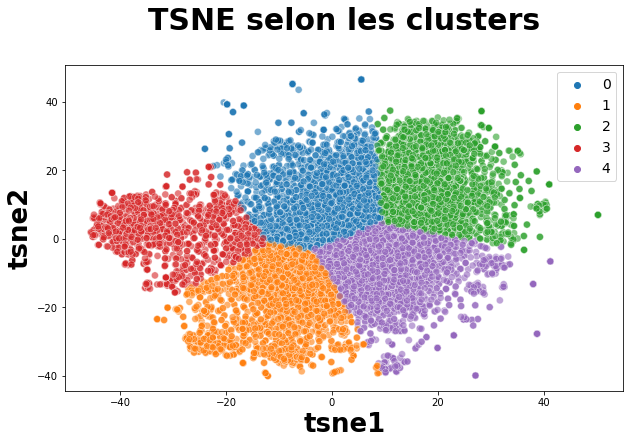

ARI :  0.12614728143457402


In [25]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x="tsne1",
                y="tsne2",
                hue="cluster",
                palette=sns.color_palette('tab10', n_colors=5),
                s=50,
                alpha=0.6,
                data=df_tsne,
                legend="brief")

plt.title('TSNE selon les clusters', fontsize=30, pad=35, fontweight='bold')
plt.xlabel('tsne1', fontsize=26, fontweight='bold')
plt.ylabel('tsne2', fontsize=26, fontweight='bold')
plt.legend(prop={'size': 14})

plt.show()

labels = sample_df_photo["label"]
print("ARI : ", metrics.adjusted_rand_score(labels, cls.labels_))

Nous avons un score ARI très faible.

### Analyse par classes

La matrice de confusion doit être transformée pour avoir en colonne le même ordre des catégories supposées qu'en ligne.

Cette transformation atteint ses limites pour les 3 catégories "interior", "outside" et "drink" qui sont peu séparées (donc elle a été réalisée manuellement au lieu d'utiliser la fonction "argmax").

In [26]:
df_tsne.groupby("cluster").size()

cluster
0    1588
1    1699
2    1679
3    1185
4    1849
dtype: int64

Nous allons calculer le nombre de chaque classes par cluster.

In [27]:
class_count_by_cluster = pd.DataFrame(
    df_tsne.groupby(['cluster', 'class']).size())
class_count_by_cluster = class_count_by_cluster.rename(columns={0: "count"})
class_count_by_cluster.style.background_gradient()

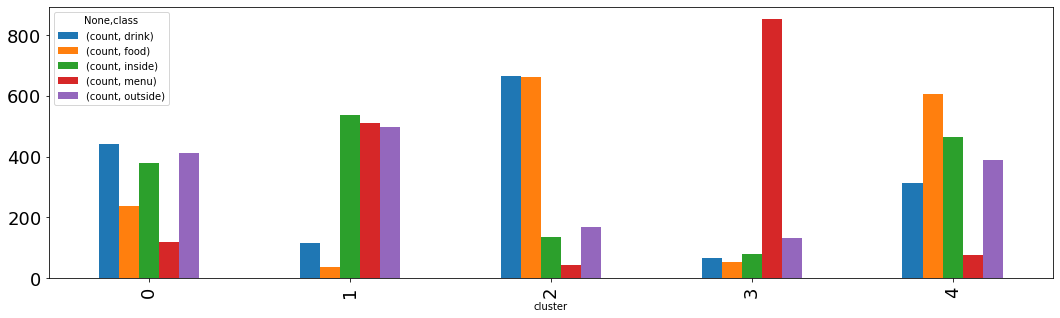

In [28]:
ax = class_count_by_cluster.unstack().plot(kind='bar', figsize=(18, 5))
ax.tick_params(axis='both', which='major', labelsize=18)

Nous avons ici des clusters assez cohérents:

Mais chaque image peut représenter plusieurs classes, souvent les images de menu prenne tous les cadre.

Voyons maintenant la similarité entre les clusters avec la confusion matrix.

In [29]:
conf_mat = metrics.confusion_matrix(labels, cls.labels_)
print(conf_mat)

[[440 116 666  66 312]
 [239  38 663  53 607]
 [380 538 137  81 464]
 [118 509  45 851  77]
 [411 498 168 134 389]]


In [30]:
def conf_mat_transform(y_true, y_pred):
    conf_mat = metrics.confusion_matrix(y_true, y_pred)

    # corresp = np.argmax(conf_mat, axis=0)
    corresp = [0, 1, 2, 3, 4]
    print("Correspondance des clusters : ", corresp)
    # y_pred_transform = np.apply_along_axis(correspond_fct, 1, y_pred)
    labels = pd.Series(y_true, name="y_true").to_frame()
    labels['y_pred'] = y_pred
    labels['y_pred_transform'] = labels['y_pred'].apply(lambda x: corresp[x])

    return labels['y_pred_transform']


cls_labels_transform = conf_mat_transform(labels, cls.labels_)
conf_mat = metrics.confusion_matrix(labels, cls_labels_transform)
print(conf_mat)
print()
print(metrics.classification_report(labels, cls_labels_transform))

Correspondance des clusters :  [0, 1, 2, 3, 4]
[[440 116 666  66 312]
 [239  38 663  53 607]
 [380 538 137  81 464]
 [118 509  45 851  77]
 [411 498 168 134 389]]

              precision    recall  f1-score   support

           0       0.28      0.28      0.28      1600
           1       0.02      0.02      0.02      1600
           2       0.08      0.09      0.08      1600
           3       0.72      0.53      0.61      1600
           4       0.21      0.24      0.23      1600

    accuracy                           0.23      8000
   macro avg       0.26      0.23      0.24      8000
weighted avg       0.26      0.23      0.24      8000



<AxesSubplot:>

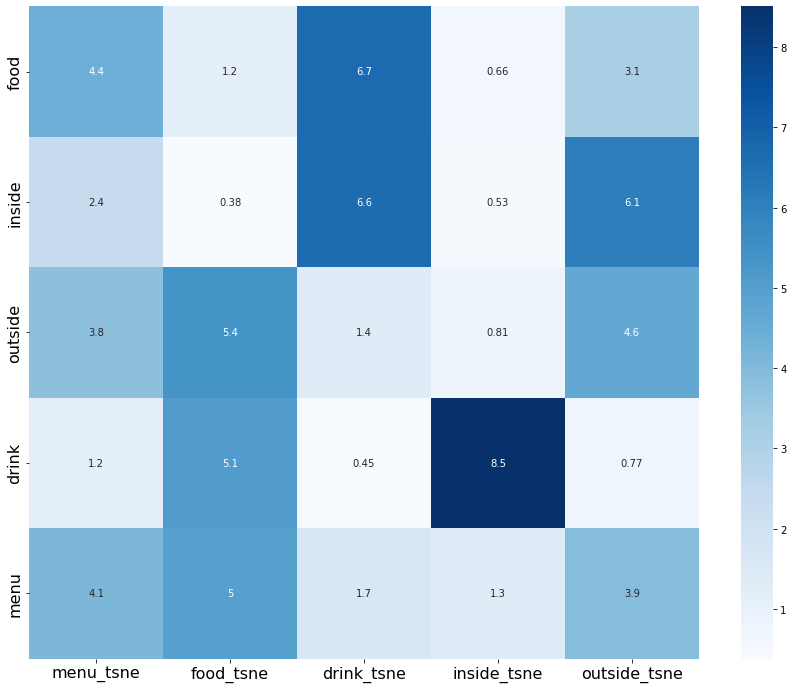

In [31]:
df_cm = pd.DataFrame(conf_mat,
                     index=[label for label in list_labels],
                     columns=[i for i in "01234"])

# Rename les colonnes avec le noms des cluster t-sne
df_cm.rename(columns={
    "0": 'menu_tsne',
    '1': 'food_tsne',
    '2': 'drink_tsne',
    '3': "inside_tsne",
    '4': "outside_tsne"
},
             inplace=True)

plt.figure(figsize=(15, 12))
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
# Nous avons divisé les valeurs par 100 pour une meilleurs lisiblité
sns.heatmap(df_cm / 100, annot=True, cmap="Blues")

Avec la matrice de confusion, cela n'est pas très convaincant, voyons voir les résultats que nous pouvons obtenir avec le Transfert Learning.

# Transfert Learning

source : https://www.tensorflow.org/tutorials/images/transfer_learning_with_hub

Le **Transfert Learning** fait généralement référence à un processus dans lequel un modèle formé sur un problème est utilisé sur un autre problème.

Dans le **deep learning**, l'apprentissage par transfert est une technique par laquelle un modèle de réseau neuronal est d'abord formé sur un problème similaire pour ensuite être utilisé sur problème à résoudre.

**DISCLAMER :** 

Nous avions fait un algorithme pour classer nos images par dossier comme ceci :

Dans ce dossier "data\yelp_photos" nous avons deux dossiers :
- training_set
- validation_set

Dans chacun de ces deux dossiers, nous avons un dossier:
- drink
- food
- inside
- menu
- outside

Chaque fichier du fichier training_set possède environ 1000 photos, pour le validation_set, chaque fichier possède environ 600 photos.

Nous avons supprimé les cellules qui rangeaient les images.

## Classificateur ImageNet

Nous allons utiliser un modèle de classificateur pré-formé sur l'ensemble de données de référence ImageNet.

### Télécharger le classificateur

Nous sélectionnons un modèle pré-entraîné MobileNetV2 à partir de TensorFlow Hub et l'encapsulons en tant que couche Keras avec hub.KerasLayer.

In [32]:
mobilenet_v2 = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4"
inception_v3 = "https://tfhub.dev/google/imagenet/inception_v3/classification/5"

classifier_model = mobilenet_v2

In [33]:
IMAGE_SHAPE = (224, 224)

classifier = tf.keras.Sequential(
    [hub.KerasLayer(classifier_model, input_shape=IMAGE_SHAPE + (3, ))])

2022-06-21 19:41:20.704648: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Test du modèle sur une image

Essayons le modèle sur une image de nourriture.

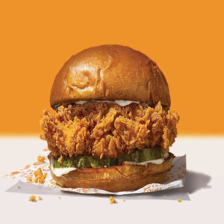

In [34]:
image_test = Image.open(
    "data/yelp_photos/training_set/food/0dDwpPV_tN_N6jum0fwrow.jpg").resize(
        IMAGE_SHAPE)
image_test

In [35]:
image_test = np.array(image_test) / 255.0
image_test.shape

(224, 224, 3)

In [36]:
result = classifier.predict(image_test[np.newaxis, ...])
result.shape

2022-06-21 19:41:22.582320: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-06-21 19:41:22.589499: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 4007995000 Hz


(1, 1001)

In [37]:
predicted_class = tf.math.argmax(result[0], axis=-1)
predicted_class

<tf.Tensor: shape=(), dtype=int64, numpy=934>

#### Décodons les prédictions

Nous prenons l'ID **predicted_class** et récupérons les étiquettes de l'ensemble de données ImageNet pour décoder les prédictions.

In [38]:
labels_path = tf.keras.utils.get_file(
    'ImageNetLabels.txt',
    'https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt'
)
imagenet_labels = np.array(open(labels_path).read().splitlines())

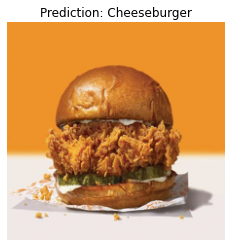

In [39]:
plt.imshow(image_test)
plt.axis('off')
predicted_class_name = imagenet_labels[predicted_class]
_ = plt.title("Prediction: " + predicted_class_name.title())

Super, le modèle reconnait bien l'image.

Commençons notre transfer learning.

#### Préparation de nos données

In [40]:
data_root_train_food = "data/yelp_photos/training_set"
data_root_validation_food = "data/yelp_photos/validation_set"

In [41]:
batch_size = 32
img_height = 224
img_width = 224

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    str(data_root_train_food),
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    str(data_root_validation_food),
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 4990 files belonging to 5 classes.
Using 3992 files for training.
Found 3000 files belonging to 5 classes.
Using 600 files for validation.


Nous avons bien ici nos photo d'entrainement et nos photos de validation.

In [42]:
# Classe 
class_names = np.array(train_ds.class_names)
print(class_names)

['drink' 'food' 'inside' 'menu' 'outside']


Deuxièmement, étant donné que la convention de TensorFlow Hub pour les modèles d'image est d'attendre des entrées flottantes dans la plage [0, 1], nous allons utiliser la couche de prétraitement tf.keras.layers.Rescaling.

In [43]:
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1. /
                                                                           255)
train_ds = train_ds.map(
    lambda x, y: (normalization_layer(x), y))  # Where x—images, y—labels.
val_ds = val_ds.map(lambda x, y:
                    (normalization_layer(x), y))  # Where x—images, y—labels.

In [44]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [45]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 224, 224, 3)
(32,)


2022-06-21 19:41:28.384484: W tensorflow/core/kernels/data/cache_dataset_ops.cc:757] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


#### Exécution du classifieur sur un lot d'images

In [46]:
%%time
result_batch = classifier.predict(train_ds)

2022-06-21 19:42:07.388738: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


CPU times: user 5min 57s, sys: 47.9 s, total: 6min 45s
Wall time: 1min


In [47]:
predicted_class_names = imagenet_labels[tf.math.argmax(result_batch, axis=-1)]
predicted_class_names

array(['pot', 'apron', 'eggnog', ..., 'chocolate sauce', 'grocery store',
       'beer bottle'], dtype='<U30')

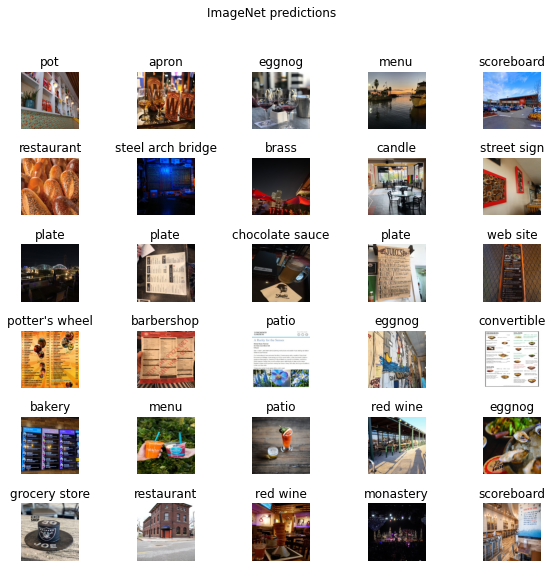

In [48]:
plt.figure(figsize=(10, 9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
    plt.subplot(6, 5, n + 1)
    plt.imshow(image_batch[n])
    plt.title(predicted_class_names[n])
    plt.axis('off')
_ = plt.suptitle("ImageNet predictions")

Les résultats sont loin d'être parfaits, et nous devons avoir seulement 5 classes. Le modèle pour l'instant prédit le contenu de l'image avec trop de précision. Exemple :

Au lieu de prédire la classe "boisson" il va prédire "mojito".

TensorFlow Hub distribue également des modèles sans la couche de classification supérieure. Ceux-ci peuvent être utilisés pour effectuer facilement un apprentissage par transfert.

In [49]:
mobilenet_v2 = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
inception_v3 = "https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/4"

feature_extractor_model = mobilenet_v2

Nous créions l'extracteur de caractéristiques en enveloppant le modèle pré-formé en tant que couche Keras avec hub.KerasLayer.

In [50]:
feature_extractor_layer = hub.KerasLayer(feature_extractor_model,
                                         input_shape=(224, 224, 3),
                                         trainable=False)

In [51]:
feature_batch = feature_extractor_layer(image_batch)
print(feature_batch.shape)

(32, 1280)


Pour terminer le modèle, nous encapsulons la couche d'extraction d'entités dans un modèle tf.keras.Sequential et ajoutons une couche entièrement connectée pour la classification.

In [52]:
num_classes = len(class_names)

model = tf.keras.Sequential(
    [feature_extractor_layer,
     tf.keras.layers.Dense(num_classes)])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 5)                 6405      
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


In [53]:
predictions = model(image_batch)

In [54]:
predictions.shape

TensorShape([32, 5])

## Entrainement du modèle

In [55]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['acc'])

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir,
    histogram_freq=1)  # Activer le calcul de l'histogramme pour chaque epoch.

2022-06-21 19:42:39.566504: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2022-06-21 19:42:39.566585: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2022-06-21 19:42:39.568177: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.


In [56]:
%%time
NUM_EPOCHS = 10

history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=NUM_EPOCHS,
                    callbacks=tensorboard_callback)

Epoch 1/10
  1/125 [..............................] - ETA: 6:39 - loss: 1.9270 - acc: 0.1250

2022-06-21 19:42:42.972303: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2022-06-21 19:42:42.972353: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.


  2/125 [..............................] - ETA: 1:12 - loss: 1.9194 - acc: 0.1328

2022-06-21 19:42:43.440737: I tensorflow/core/profiler/lib/profiler_session.cc:71] Profiler session collecting data.
2022-06-21 19:42:43.452984: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2022-06-21 19:42:43.475144: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: logs/fit/20220621-194239/train/plugins/profile/2022_06_21_19_42_43
2022-06-21 19:42:43.479992: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for trace.json.gz to logs/fit/20220621-194239/train/plugins/profile/2022_06_21_19_42_43/Boskoop.trace.json.gz
2022-06-21 19:42:43.503878: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: logs/fit/20220621-194239/train/plugins/profile/2022_06_21_19_42_43
2022-06-21 19:42:43.507516: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for memory_profile.json.gz to logs/fit/20220621-194239/train/plugins/profile/2022_06_21_1

125/125 [==============================] - 62s 471ms/step - loss: 0.7529 - acc: 0.7210 - val_loss: 0.1920 - val_acc: 0.9350
Epoch 2/10
125/125 [==============================] - 55s 437ms/step - loss: 0.1783 - acc: 0.9443 - val_loss: 0.1720 - val_acc: 0.9367
Epoch 3/10
125/125 [==============================] - 55s 439ms/step - loss: 0.1406 - acc: 0.9532 - val_loss: 0.1713 - val_acc: 0.9367
Epoch 4/10
125/125 [==============================] - 58s 464ms/step - loss: 0.1167 - acc: 0.9596 - val_loss: 0.1759 - val_acc: 0.9350
Epoch 5/10
125/125 [==============================] - 70s 563ms/step - loss: 0.0992 - acc: 0.9669 - val_loss: 0.1824 - val_acc: 0.9300
Epoch 6/10
125/125 [==============================] - 65s 519ms/step - loss: 0.0857 - acc: 0.9745 - val_loss: 0.1892 - val_acc: 0.9300
Epoch 7/10
125/125 [==============================] - 62s 499ms/step - loss: 0.0747 - acc: 0.9796 - val_loss: 0.1954 - val_acc: 0.9283
Epoch 8/10
125/125 [==============================] - 63s 501ms/st

### Vérification

Obtenons la liste ordonnée des noms de classe à partir des prédictions du modèle.

In [57]:
predicted_batch = model.predict(image_batch)
predicted_id = tf.math.argmax(predicted_batch, axis=-1)
predicted_label_batch = class_names[predicted_id]
print(predicted_label_batch)

['inside' 'drink' 'drink' 'outside' 'outside' 'food' 'inside' 'outside'
 'inside' 'inside' 'outside' 'menu' 'drink' 'menu' 'menu' 'menu' 'menu'
 'menu' 'inside' 'menu' 'menu' 'drink' 'drink' 'outside' 'food' 'drink'
 'outside' 'inside' 'outside' 'inside' 'outside' 'inside']


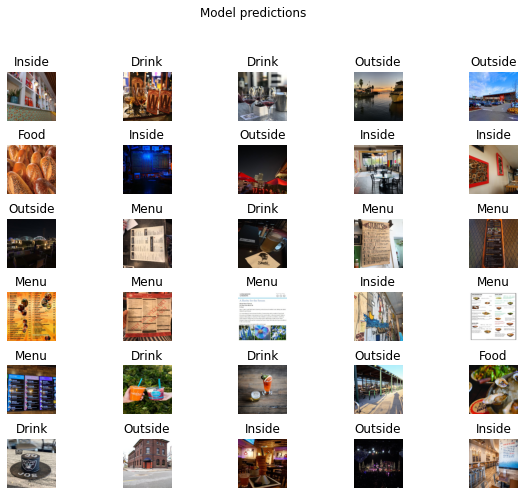

In [58]:
plt.figure(figsize=(10, 9))
plt.subplots_adjust(hspace=0.5)

for n in range(30):
    plt.subplot(7, 5, n + 1)
    plt.imshow(image_batch[n])
    plt.title(predicted_label_batch[n].title())
    plt.axis('off')
_ = plt.suptitle("Model predictions")

Le modèle détécte très bien les différentes images.

In [63]:
%tensorboard --logdir logs/fit

Reusing TensorBoard on port 6006 (pid 297), started 4 days, 9:50:32 ago. (Use '!kill 297' to kill it.)

- **"loss"** fait référence à la valeur de la perte sur les données d'entraînement après chaque époque. Il s'agit de ce que le processus d'optimisation tente de minimiser avec la formation, donc plus elle est faible, mieux c'est.

- La **"accuracy"** fait référence au rapport entre les prédictions correctes et le nombre total de prédictions dans les données d'apprentissage. Plus elle est élevée, mieux c'est. Ce rapport est normalement inversement corrélé avec la perte, mais pas toujours.

In [85]:
liste_val = history.history['val_acc']
moyenne = sum(liste_val)/len(liste_val)
print(moyenne)

0.9270000100135803


Nous avons alors un score moyen de 0.92.

## Exportez et rechargez votre modèle

Maintenant que nous avons formé le modèle, exportons-le en tant que modèle enregistré pour le réutiliser ultérieurement.

In [61]:
t = time.time()

export_path = "./saved_model/{}".format(int(t))
model.save(export_path)

export_path

2022-06-21 18:59:29.227858: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ./saved_model/1655830768/assets


INFO:tensorflow:Assets written to: ./saved_model/1655830768/assets


'./saved_model/1655830768'

Vérifions que nous pouvons recharger notre modèle et qu'il est capable de générer les mêmes résultats.

In [62]:
reloaded = tf.keras.models.load_model(export_path)

In [63]:
result_batch = model.predict(image_batch)
reloaded_result_batch = reloaded.predict(image_batch)

In [64]:
abs(reloaded_result_batch - result_batch).max()

0.0

In [65]:
reloaded_predicted_id = tf.math.argmax(reloaded_result_batch, axis=-1)
reloaded_predicted_label_batch = class_names[reloaded_predicted_id]
print(reloaded_predicted_label_batch)

['inside' 'drink' 'drink' 'outside' 'outside' 'food' 'inside' 'outside'
 'inside' 'inside' 'outside' 'menu' 'drink' 'menu' 'menu' 'menu' 'menu'
 'menu' 'inside' 'menu' 'menu' 'drink' 'drink' 'outside' 'food' 'drink'
 'outside' 'inside' 'outside' 'inside' 'outside' 'inside']


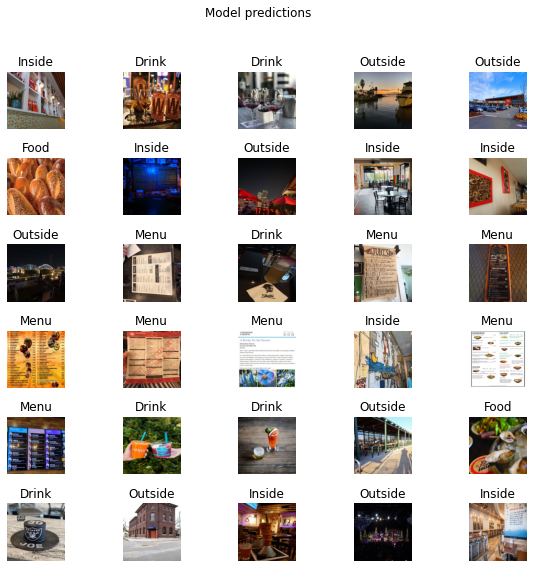

In [66]:
plt.figure(figsize=(10, 9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
    plt.subplot(6, 5, n + 1)
    plt.imshow(image_batch[n])
    plt.title(reloaded_predicted_label_batch[n].title())
    plt.axis('off')
_ = plt.suptitle("Model predictions")

# Conclusion

Le transfert learning a été le meilleur moyen pour analyser les photos et déterminer leurs catégories.

Nous avons maintenant un modèle qui permet de catégoriser nos photos.